In [37]:
pip install pynamics

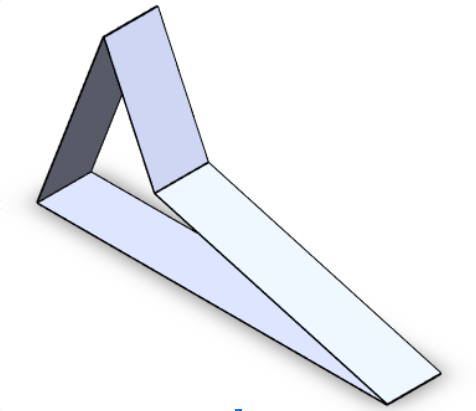

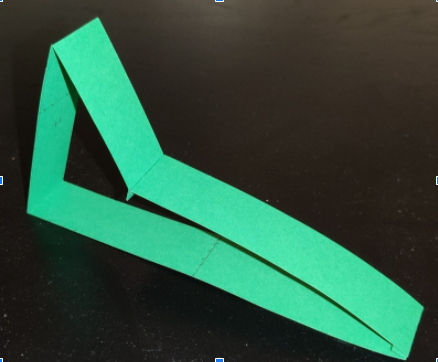

In [38]:
%matplotlib inline

In [39]:
use_constraints = True

In [40]:
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.body import Body
from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
from pynamics.particle import Particle
from pynamics.constraint import AccelerationConstraint
import pynamics.integration
import numpy
import sympy
import matplotlib.pyplot as plt
plt.ion()
from math import pi
# create a new system object and set that system as the global system within the module so that other variables can use and find it
system = System()
pynamics.set_system(__name__,system)
# Constants
lA = Constant(9,'lA',system)
lB = Constant(4.5,'lB',system)
lC = Constant(7,'lC',system)
lD = Constant(13,'lD',system)

mA = Constant(1,'mA',system)
mB = Constant(1,'mB',system)
mC = Constant(1,'mC',system)
mD = Constant(1,'mD',system)

g = Constant(9.81,'g',system)
b = Constant(1e1,'b',system) #dampening coefficient
k = Constant(1e1,'k',system) 

preload1 = Constant(0*pi/180,'preload1',system)
preload2 = Constant(0*pi/180,'preload2',system)
preload3 = Constant(0*pi/180,'preload3',system)
preload4 = Constant(0*pi/180,'preload4',system)

Ixx_A = Constant(1,'Ixx_A',system)
Iyy_A = Constant(1,'Iyy_A',system)
Izz_A = Constant(1,'Izz_A',system)
Ixx_B = Constant(1,'Ixx_B',system)
Iyy_B = Constant(1,'Iyy_B',system)
Izz_B = Constant(1,'Izz_B',system)
Ixx_C = Constant(1,'Ixx_C',system)
Iyy_C = Constant(1,'Iyy_C',system)
Izz_C = Constant(1,'Izz_C',system)
Ixx_D = Constant(1,'Ixx_D',system)
Iyy_D = Constant(1,'Iyy_D',system)
Izz_D = Constant(1,'Izz_D',system)

torque = Constant(0,'torque',system)
freq = Constant(3e0,'freq',system)

In [41]:
#Define your differentiable state variables that you will use to model the state of the system
qA,qA_d,qA_dd = Differentiable('qA',system)
qB,qB_d,qB_dd = Differentiable('qB',system)
qC,qC_d,qC_dd = Differentiable('qC',system)
qD,qD_d,qD_dd = Differentiable('qD',system)

In [42]:
# Define a set of initial values for the position and velocity of each of your state variables. It is necessary to define a known. This code create a dictionary of initial values.
initialvalues = {}
initialvalues[qA]=75*pi/180
initialvalues[qA_d]=0*pi/180
initialvalues[qB]=-50*pi/180
initialvalues[qB_d]=0*pi/180
initialvalues[qC]=135*pi/180
initialvalues[qC_d]=0*pi/180
initialvalues[qD]=90*pi/180
initialvalues[qD_d]=0*pi/180
# order the initial values in a list in such a way that the integrator can use it in the same order that it expects the variables to be supplied
statevariables = system.get_state_variables()
ini = [initialvalues[item] for item in statevariables]
#Define frames of system
N = Frame('N',system)
A = Frame('A',system)
B = Frame('B',system)
C = Frame('C',system)
D = Frame('D',system)
#define the Newtonian reference frame as a reference frame that is not accelerating, otherwise the dynamic equations will not be correct
system.set_newtonian(N)
#Rotate each successive frame by amount q from the last
A.rotate_fixed_axis(N,[0,0,1],qA,system)
B.rotate_fixed_axis(A,[0,0,1],qB,system)
C.rotate_fixed_axis(B,[0,0,1],qC,system)
D.rotate_fixed_axis(C,[0,0,1],qD,system)

In [43]:
#Vectros: Define the vectors that describe the kinematics of a series of connected lengths
pNA=0*N.x
pAB=pNA+lA*A.x
pBC = pAB + lB*B.x
pCtip = pBC + lC*C.x
PDA= pCtip+lD*D.x
#Center of mass of each link
pAcm=pNA+lA/2*A.x
pBcm=pAB+lB/2*B.x
pCcm=pBC+lC/2*C.x
pDcm=pCtip+lC/2*C.x

In [44]:
#Angular velocity get angular velocity
wNA = N.get_w_to(A)
wAB = A.get_w_to(B)
wBC = B.get_w_to(C)
wCD = B.get_w_to(D)

In [45]:
#Vector derivative
vCtip = pCtip.time_derivative(N,system)

#compute the inertia of each body and define a rigid body on each frame. 
#In the case of frame C, we represent the mass as a particle located at point pCcm.
IA = Dyadic.build(A,Ixx_A,Iyy_A,Izz_A)
IB = Dyadic.build(B,Ixx_B,Iyy_B,Izz_B)
IC = Dyadic.build(C,Ixx_C,Iyy_C,Izz_C)
ID = Dyadic.build(D,Ixx_D,Iyy_D,Izz_D)

BodyA = Body('BodyA',A,pAcm,mA,IA,system)
BodyB = Body('BodyB',B,pBcm,mB,IB,system)
BodyC = Body('BodyC',C,pCcm,mC,IC,system)
BodyD = Body('BodyD',D,pDcm,mD,ID,system)
#BodyC = Particle(pCcm,mC,'ParticleC',system)

In [46]:
#Forces and torques are added to the system with the generic addforce method.
#The first parameter supplied is a vector describing the force applied at a point or the torque applied along a given rotational axis
#The second parameter is the vector describing the linear speed (for an applied force) or the angular velocity(for an applied torque)

system.addforce(torque*sympy.sin(freq*2*sympy.pi*system.t)*A.z,wNA)

#Damper
system.addforce(-b*wNA,wNA)
system.addforce(-b*wAB,wAB)
system.addforce(-b*wBC,wBC)


In [47]:
#Spring forces are a special case because the energy stored in springs is conservative and should be considered when calculating the system’s potential energy.
#To do this, use the add_spring_force command. In this method, the first value is the linear spring constant.
#The second value is the “stretch” vector, indicating the amount of deflection from the neutral point of the spring
#The final parameter is, as above, the linear or angluar velocity vector (depending on whether your spring is a linear or torsional spring)
#In this case, the torques applied to each joint are dependent upon whether qA, qB, and qC are absolute or relative rotations, as defined above.
system.add_spring_force1(k,(qA-preload1)*N.z,wNA) 
system.add_spring_force1(k,(qB-preload2)*A.z,wAB)
system.add_spring_force1(k,(qC-preload3)*B.z,wBC)

(<pynamics.force.Force at 0x7facb1f64dd0>,
 <pynamics.spring.Spring at 0x7facb1f64d50>)

In [48]:
#Again, like springs, the force of gravity is conservative and should be applied to all bodies
#To globally apply the force of gravity to all particles and bodies, 
#you can use the special addforcegravity method, by supplying the acceleration due to gravity as a vector
#This will get applied to all bodies defined in your system.
system.addforcegravity(-g*N.y)

In [49]:
#Constraints may be defined that prevent the motion of certain elements. 
#Try turning on the constraints flag at the top of the script to see what happens.
if use_constraints:
    eq = []
    eq.append(pCtip)
    eq_d=[item.time_derivative() for item in eq]
    eq_dd=[item.time_derivative() for item in eq_d]
    eq_dd_scalar = []
    eq_dd_scalar.append(eq_dd[0].dot(N.x))
    eq_dd_scalar.append(eq_dd[0].dot(N.y))
    constraint = AccelerationConstraint(eq_dd_scalar)
    system.add_constraint(constraint)

#This is where the symbolic expressions for F and ma are calculated
#This must be done after all parts of the system have been defined
#The getdynamics function uses Kane’s method to derive the equations of motion.
f,ma = system.getdynamics()
f
ma


2022-02-25 04:34:59,167 - pynamics.system - INFO - getting dynamic equations


[Izz_A*qA_dd + Izz_B*(qA_dd + qB_dd) + Izz_C*(qA_dd + qB_dd + qC_dd) + Izz_D*(qA_dd + qB_dd + qC_dd + qD_dd) + lA**2*mA*qA_dd/4 + lA**2*mB*qA_dd + lA**2*mC*qA_dd + lA**2*mD*qA_dd + lA*lB*mB*qA_d**2*sin(qB)/2 + lA*lB*mB*qA_dd*cos(qB)/2 - lA*lB*mB*(qA_d + qB_d)**2*sin(qB)/2 + lA*lB*mC*qA_d**2*sin(qB) + lA*lB*mC*qA_dd*cos(qB) - lA*lB*mC*(qA_d + qB_d)**2*sin(qB) + lA*lB*mD*qA_d**2*sin(qB) + lA*lB*mD*qA_dd*cos(qB) - lA*lB*mD*(qA_d + qB_d)**2*sin(qB) + lA*mB*(lB*qA_dd/2 + lB*qB_dd/2)*cos(qB) + lA*mC*(lB*qA_dd + lB*qB_dd)*cos(qB) + lA*mD*(lB*qA_dd + lB*qB_dd)*cos(qB) + lA*(-lC*mC*(qA_d + qB_d + qC_d)**2*sin(qC)/2 + mC*(lC*qA_dd/2 + lC*qB_dd/2 + lC*qC_dd/2)*cos(qC))*cos(qB) + lA*(-lC*mC*(qA_d + qB_d + qC_d)**2*cos(qC)/2 - mC*(lC*qA_dd/2 + lC*qB_dd/2 + lC*qC_dd/2)*sin(qC))*sin(qB) + lA*(-3*lC*mD*(qA_d + qB_d + qC_d)**2*sin(qC)/2 + mD*(3*lC*qA_dd/2 + 3*lC*qB_dd/2 + 3*lC*qC_dd/2)*cos(qC))*cos(qB) + lA*(-3*lC*mD*(qA_d + qB_d + qC_d)**2*cos(qC)/2 - mD*(3*lC*qA_dd/2 + 3*lC*qB_dd/2 + 3*lC*qC_dd/2)*si

The next line of code solves the system of equations F=ma plus any constraint equations that have been added above. It returns one or two variables. func1 is the function that computes the velocity and acceleration given a certain state, and lambda1(optional) supplies the function that computes the constraint forces as a function of the resulting states

There are a few ways of solveing for a. The below function inverts the mass matrix numerically every time step. This can be slower because the matrix solution has to be solved for, but is sometimes more tractable than solving the highly nonlinear symbolic expressions that can be generated from the previous step. The other options would be to use state_space_pre_invert, which pre-inverts the equations symbolically before generating a numerical function, or state_space_post_invert2, which adds Baumgarte’s method for intermittent constraints.


In [50]:
func1,lambda1 = system.state_space_post_invert(f,ma,return_lambda = True)

2022-02-25 04:35:00,190 - pynamics.system - INFO - solving a = f/m and creating function
2022-02-25 04:35:00,503 - pynamics.system - INFO - substituting constrained in Ma-f.
2022-02-25 04:35:00,794 - pynamics.system - INFO - done solving a = f/m and creating function
2022-02-25 04:35:00,797 - pynamics.system - INFO - calculating function for lambdas


In [51]:
#Specify the precision of the integration
tol = 1e-5

#Define variables for time that can be used throughout the script. 
#These get used to create the t array, a list of every time value that is solved for during integration
tinitial = 0
tfinal = 10
fps = 30
tstep = 1/fps
t = numpy.r_[tinitial:tfinal:tstep]

In [52]:
#Integrate
#The next line of code integrates the function calculated
states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol, args=({'constants':system.constant_values},))

2022-02-25 04:35:00,822 - pynamics.integration - INFO - beginning integration
2022-02-25 04:35:00,824 - pynamics.system - INFO - integration at time 0000.00
2022-02-25 04:35:01,114 - pynamics.integration - INFO - finished integration


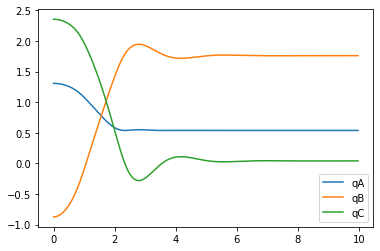

In [53]:
#States
plt.figure()
artists = plt.plot(t,states[:,:3])
plt.legend(artists,['qA','qB','qC'])

2022-02-25 04:35:01,420 - pynamics.output - INFO - calculating outputs
2022-02-25 04:35:01,446 - pynamics.output - INFO - done calculating outputs


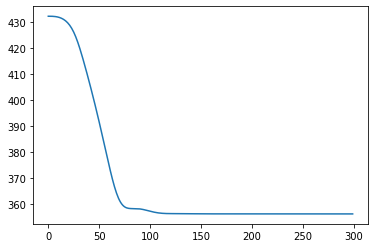

In [54]:
#Energy
KE = system.get_KE()
PE = system.getPEGravity(pNA) - system.getPESprings()
energy_output = Output([KE-PE],system)
energy_output.calc(states,t)
energy_output.plot_time()

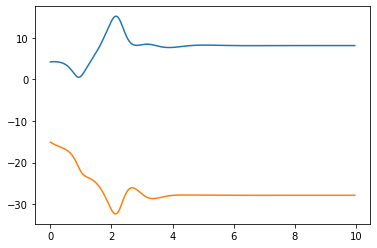

In [55]:
#Constraint Forces
#This line of code computes the constraint forces once the system’s states have been solved for.

if use_constraints:
    lambda2 = numpy.array([lambda1(item1,item2,system.constant_values) for item1,item2 in zip(t,states)])
    plt.figure()
    plt.plot(t, lambda2)

2022-02-25 04:35:02,142 - pynamics.output - INFO - calculating outputs
2022-02-25 04:35:02,161 - pynamics.output - INFO - done calculating outputs


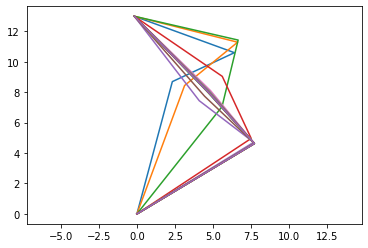

In [56]:
#Motion
points = [pNA,pAB,pBC,pCtip]
points_output = PointsOutput(points,system)
y = points_output.calc(states,t)
points_output.plot_time(20)

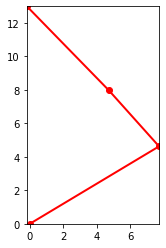

In [57]:
#Motion Animation
#in normal Python the next lines of code produce an animation using matplotlib

points_output.animate(fps = fps,movie_name = 'triple_pendulum.mp4',lw=2,marker='o',color=(1,0,0,1),linestyle='-')

In [58]:
#To plot the animation in jupyter you need a couple extra lines of code…

from matplotlib import animation, rc
from IPython.display import HTML
HTML(points_output.anim.to_html5_video())

In [59]:
statevariables = system.get_state_variables()
ini0 = [initialvalues[item] for item in statevariables]

eq_vector = [pNA-pCtip]
eq_scalar = []
eq_scalar.append((eq_vector[0]).dot(N.x))
eq_scalar.append((eq_vector[0]).dot(N.y))
eq_scalar.append(qC-0)
eq_scalar

qi = [qA]
qd = [qB,qC,qD]

eq_scalar_c = [item.subs(system.constant_values) for item in eq_scalar]
defined = dict([(item,initialvalues[item]) for item in qi])
eq_scalar_c = [item.subs(defined) for item in eq_scalar_c]
eq_scalar_c


[-7*(-0.965925826289068*sin(qB) + 0.258819045102521*cos(qB))*cos(qC) - 7*(-0.258819045102521*sin(qB) - 0.965925826289068*cos(qB))*sin(qC) + 4.34666621830081*sin(qB) - 1.16468570296134*cos(qB) - 2.32937140592269, -7*(-0.965925826289068*sin(qB) + 0.258819045102521*cos(qB))*sin(qC) - 7*(0.258819045102521*sin(qB) + 0.965925826289068*cos(qB))*cos(qC) - 1.16468570296134*sin(qB) - 4.34666621830081*cos(qB) - 8.69333243660162, qC]

2022-02-25 04:35:55,268 - pynamics.output - INFO - calculating outputs
2022-02-25 04:35:55,275 - pynamics.output - INFO - done calculating outputs


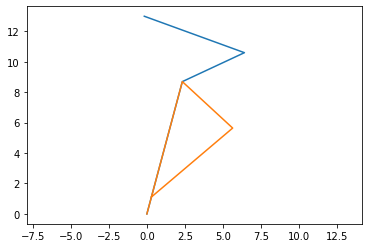

In [60]:
import scipy.optimize
error = (numpy.array(eq_scalar_c)**2).sum()

f = sympy.lambdify(qd,error)

def function(args):
    return f(*args)

guess = [initialvalues[item] for item in qd]

result = scipy.optimize.minimize(function,guess)
#Commented because it gives error otherwise
if result.fun>23:
    raise(Exception("out of tolerance"))

ini = []
for item in system.get_state_variables():
    if item in qd:
        ini.append(result.x[qd.index(item)])
    else:
        ini.append(initialvalues[item])

points = PointsOutput(points, constant_values=system.constant_values)
points.calc(numpy.array([ini0,ini]),numpy.array([0,1]))
points.plot_time()

In [61]:
import sympy as sp
VBtip=pAB.time_derivative()

vBtip_x=VBtip.dot(N.x)
vBtip_y=VBtip.dot(N.y)
v=sp.Matrix([vBtip_x,vBtip_y])

q_d=sp.Matrix([qA_d,qB_d,qC_d,qD_d])

J=v.jacobian(q_d)
print(J)

Matrix([[-lA*sin(qA), 0, 0, 0], [lA*cos(qA), 0, 0, 0]])


In [62]:
J1=[item.subs(system.constant_values) for item in J]
J1=[item.subs(initialvalues) for item in J1]
print(J1)

[-8.69333243660162, 0, 0, 0, 2.32937140592269, 0, 0, 0]


In [63]:
import numpy as np
f=sp.Matrix([200,0])
J1t=np.transpose(J1)
print(J1t)

[-8.69333243660162 0 0 0 2.32937140592269 0 0 0]


In [64]:
qdot=sp.Matrix([43,2.4])
J1=np.reshape(J1,(4,2))
v1=np.matmul(J1,qdot)
print(J1)

[[-8.69333243660162 0]
 [0 0]
 [2.32937140592269 0]
 [0 0]]


In [65]:
eq_d=[(system.derivative(item)) for item in eq_scalar]
eq_d = sympy.Matrix(eq_d)
eq_d = eq_d.subs(system.constant_values)
eq_d

Matrix([
[qA_d*(7*(-sin(qA)*sin(qB) + cos(qA)*cos(qB))*sin(qC) + 7*(sin(qA)*cos(qB) + sin(qB)*cos(qA))*cos(qC) + 4.5*sin(qA)*cos(qB) + 9*sin(qA) + 4.5*sin(qB)*cos(qA)) + qB_d*(7*(-sin(qA)*sin(qB) + cos(qA)*cos(qB))*sin(qC) + 7*(sin(qA)*cos(qB) + sin(qB)*cos(qA))*cos(qC) + 4.5*sin(qA)*cos(qB) + 4.5*sin(qB)*cos(qA)) + qC_d*(-7*(sin(qA)*sin(qB) - cos(qA)*cos(qB))*sin(qC) + 7*(sin(qA)*cos(qB) + sin(qB)*cos(qA))*cos(qC))],
[  qA_d*(7*(sin(qA)*sin(qB) - cos(qA)*cos(qB))*cos(qC) + 7*(sin(qA)*cos(qB) + sin(qB)*cos(qA))*sin(qC) + 4.5*sin(qA)*sin(qB) - 4.5*cos(qA)*cos(qB) - 9*cos(qA)) + qB_d*(7*(sin(qA)*sin(qB) - cos(qA)*cos(qB))*cos(qC) + 7*(sin(qA)*cos(qB) + sin(qB)*cos(qA))*sin(qC) + 4.5*sin(qA)*sin(qB) - 4.5*cos(qA)*cos(qB)) + qC_d*(7*(sin(qA)*sin(qB) - cos(qA)*cos(qB))*cos(qC) - 7*(-sin(qA)*cos(qB) - sin(qB)*cos(qA))*sin(qC))],
[                                                                                                                                                                    

In [66]:
qi = sympy.Matrix([qA])
qi

Matrix([[qA]])

In [67]:
qd = sympy.Matrix([qB,qC,qD])
qd

Matrix([
[qB],
[qC],
[qD]])

In [68]:
AA = eq_d.jacobian(qi)
AA

Matrix([
[qA_d*((-7*sin(qA)*sin(qB) + 7*cos(qA)*cos(qB))*cos(qC) + (-7*sin(qA)*cos(qB) - 7*sin(qB)*cos(qA))*sin(qC) - 4.5*sin(qA)*sin(qB) + 4.5*cos(qA)*cos(qB) + 9*cos(qA)) + qB_d*((-7*sin(qA)*sin(qB) + 7*cos(qA)*cos(qB))*cos(qC) + (-7*sin(qA)*cos(qB) - 7*sin(qB)*cos(qA))*sin(qC) - 4.5*sin(qA)*sin(qB) + 4.5*cos(qA)*cos(qB)) + qC_d*((-7*sin(qA)*sin(qB) + 7*cos(qA)*cos(qB))*cos(qC) + (-7*sin(qA)*cos(qB) - 7*sin(qB)*cos(qA))*sin(qC))],
[   qA_d*((-7*sin(qA)*sin(qB) + 7*cos(qA)*cos(qB))*sin(qC) + (7*sin(qA)*cos(qB) + 7*sin(qB)*cos(qA))*cos(qC) + 4.5*sin(qA)*cos(qB) + 9*sin(qA) + 4.5*sin(qB)*cos(qA)) + qB_d*((-7*sin(qA)*sin(qB) + 7*cos(qA)*cos(qB))*sin(qC) + (7*sin(qA)*cos(qB) + 7*sin(qB)*cos(qA))*cos(qC) + 4.5*sin(qA)*cos(qB) + 4.5*sin(qB)*cos(qA)) + qC_d*((-7*sin(qA)*sin(qB) + 7*cos(qA)*cos(qB))*sin(qC) + (7*sin(qA)*cos(qB) + 7*sin(qB)*cos(qA))*cos(qC))],
[                                                                                                                                      

In [69]:
BB = eq_d.jacobian(qd)
BB

Matrix([
[qA_d*((-7*sin(qA)*sin(qB) + 7*cos(qA)*cos(qB))*cos(qC) + (-7*sin(qA)*cos(qB) - 7*sin(qB)*cos(qA))*sin(qC) - 4.5*sin(qA)*sin(qB) + 4.5*cos(qA)*cos(qB)) + qB_d*((-7*sin(qA)*sin(qB) + 7*cos(qA)*cos(qB))*cos(qC) + (-7*sin(qA)*cos(qB) - 7*sin(qB)*cos(qA))*sin(qC) - 4.5*sin(qA)*sin(qB) + 4.5*cos(qA)*cos(qB)) + qC_d*((-7*sin(qA)*sin(qB) + 7*cos(qA)*cos(qB))*cos(qC) + (-7*sin(qA)*cos(qB) - 7*sin(qB)*cos(qA))*sin(qC)), qA_d*((-7*sin(qA)*sin(qB) + 7*cos(qA)*cos(qB))*cos(qC) - (7*sin(qA)*cos(qB) + 7*sin(qB)*cos(qA))*sin(qC)) + qB_d*((-7*sin(qA)*sin(qB) + 7*cos(qA)*cos(qB))*cos(qC) - (7*sin(qA)*cos(qB) + 7*sin(qB)*cos(qA))*sin(qC)) + qC_d*((-7*sin(qA)*sin(qB) + 7*cos(qA)*cos(qB))*cos(qC) - (7*sin(qA)*cos(qB) + 7*sin(qB)*cos(qA))*sin(qC)), 0],
[   qA_d*((-7*sin(qA)*sin(qB) + 7*cos(qA)*cos(qB))*sin(qC) + (7*sin(qA)*cos(qB) + 7*sin(qB)*cos(qA))*cos(qC) + 4.5*sin(qA)*cos(qB) + 4.5*sin(qB)*cos(qA)) + qB_d*((-7*sin(qA)*sin(qB) + 7*cos(qA)*cos(qB))*sin(qC) + (7*sin(qA)*cos(qB) + 7*sin(qB)*cos(q

In [70]:
#J_int= -BB.inv()*AA
#J_int.simplify()
#J_int

In [71]:
pout = pAB + 3*B.x-2*B.y
pout
vout = pout.time_derivative()
#vout = vout.subs(subs)
vout = sp.Matrix([vout.dot(N.x),vout.dot(N.y)])
vout

Matrix([
[-lA*qA_d*sin(qA) - ((2*qA_d + 2*qB_d)*sin(qB) + (3*qA_d + 3*qB_d)*cos(qB))*sin(qA) + ((2*qA_d + 2*qB_d)*cos(qB) - (3*qA_d + 3*qB_d)*sin(qB))*cos(qA)],
[ lA*qA_d*cos(qA) + ((2*qA_d + 2*qB_d)*sin(qB) + (3*qA_d + 3*qB_d)*cos(qB))*cos(qA) + ((2*qA_d + 2*qB_d)*cos(qB) - (3*qA_d + 3*qB_d)*sin(qB))*sin(qA)]])

In [72]:
Ji = vout.jacobian(qi)
Ji
Jd = vout.jacobian(qd)
Jd
#J = Ji+Jd*J_int
#J

Matrix([
[((-3*qA_d - 3*qB_d)*cos(qB) - (2*qA_d + 2*qB_d)*sin(qB))*cos(qA) + (-(2*qA_d + 2*qB_d)*cos(qB) + (3*qA_d + 3*qB_d)*sin(qB))*sin(qA), 0, 0],
[ ((-3*qA_d - 3*qB_d)*cos(qB) - (2*qA_d + 2*qB_d)*sin(qB))*sin(qA) + ((2*qA_d + 2*qB_d)*cos(qB) - (3*qA_d + 3*qB_d)*sin(qB))*cos(qA), 0, 0]])

# Disussion:

# 1.   **How many degrees of freedom does your device have? How many motors? If the answer is not the same, what determines the state of the remaining degrees of freedom? How did you arrive at that number?**

#  *The device uses a four bar linkage mechanism, which consists of 1 degree of freedom. Since it is made out of two identical but mirrored mechanisms, it will require 2 servo motors to actuate it. This means that each four bar mechanism needs only one motor.*

# 2.   **If your mechanism has more than one degree of freedom, please describe how those multiple degrees of freedom will work together to create a locomotory gait or useful motion. What is your plan for synchonizing, especially if passive energy storage?**

#  *Our mechanism has only one degree of freedom.*

# 3. **How did you estimate your expected end-effector forces**

#  *The end-effector forces were estimated based on the bite force of a Parrot Fish in the Z direction*

# 4. **How did you estimate your expected end-effector speeds**

#  *To get end effector velocity, the derivative of position change is taken with respect to time.*